# Causal Inference Modeling of COMPAS data

### Criterion for Bias
- 1) TP and TN Rate by Race
- 2) Intervention by Race
- 3) Counterfactual Fairness by Race
- 4) Natural Direct Effects Identification of Race to Recitivism
- 5) Natural Indirect Effects Identification of Race to Recitivism

### 3 SCMs of Race towards Recitivism Predictions
- 1) Indirect (Almost all expected, with some understandable results)
    - 1) TP and TN Rate by Race (Expected: 1 - 3% difference between race is understndable, but non zero value is expected)
    - 2) Intervention by Race (Expected: Small effect of around 5% is understandable, but not zero is expected)
    - 3) Counterfactual Fairness by Race (Expected: Large of 43%)
    - 4) Natural Direct Effects Identification of Race to Recitivism (Expected: No effect detected)
    - 5) Natural Indirect Effects Identification of Race to Recitivism (Expected: -24% of White -> Will not Recommit)
- 2) Direct (Expected)
    - 1) TP and TN Rate by Race (Expected: Large bias)
    - 2) Intervention by Race (Expected: Large around 10-15%)
    - 3) Counterfactual Fairness by Race (Expected: Large around 50%)
    - 4) Natural Direct Effects Identification of Race to Recitivism (Expected: Large value of -23%)
    - 5) Natural Indirect Effects Identification of Race to Recitivism (Expected: Large value of -24%)
- 3) Unaware (Expected, when natural indirect effect identification can likely be attributed to unobserved confoudner)
    - 1) TP and TN Rate by Race (Expected: Low gap of 4-5% is expected due to in line with indirect, and expected from being non-zero)
    - 2) Intervention by Race (Expected: No impact)
    - 3) Counterfactual Fairness by Race (Expected, large impact of 50%)
    - 4) Natural Direct Effects Identification of Race to Recitivism (Expected, no impact detected)
    - 5) Natural Indirect Effects Identification of Race to Recitivism (Largely Expected: Large impact of -24% was detected. Likely due to unobserved confounder of race.)

In [1]:
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import pandas as pd
import tqdm
from sklearn.metrics import confusion_matrix,roc_auc_score,accuracy_score
from statistics import mean

%matplotlib inline

pyro.set_rng_seed(42)

# Data Import

In [2]:
data_file_path = 'data/compas-scores-two-years-short.csv'

# Model 1 - Indirect by Race + Gender

### Read Model Parameters

In [5]:
# race
df = pd.read_csv('data/model1_race.csv')
race_alias = list(df['Var1'])
race_prob = torch.tensor(list(df['Freq']) )

# sex
df = pd.read_csv('data/model1_sex.csv')
sex_alias = list(df['Var1'])
sex_prob = torch.tensor(list(df['Freq']) )

# age_cat
df = pd.read_csv('data/model1_age_cat.csv')
age_cat_alias = list(df['Var1'])
age_cat_prob = torch.tensor(list(df['Freq']) )



# priors_count
df = pd.read_csv('data/model1_priors_count.csv')
priors_count_alias = list(set( df['priors_count'] ))

dic = {}
for index, row in df.iterrows():
    dic[(row['race'], row['sex'],row['age_cat'],row['priors_count'])] = row['Freq']
l0 = []
for r in race_alias:
    l1 = []
    for s in sex_alias:
        l2 = []
        for a in age_cat_alias:
            l3 = []
            for c in priors_count_alias:            
                l3 += [ dic[r,s,a,c] ]
            l2 +=  [ l3 ]
        l1 += [ l2 ]
    l0 += [ l1 ]

priors_count_probs = torch.tensor( l0 )

# two_year_recid
df = pd.read_csv('data/model1_two_year_recid.csv')
two_year_recid_alias = list(df['Unnamed: 0'])

l = []
for e in priors_count_alias:
    l += [ list( df[e] )  ]
two_year_recid_probs = torch.tensor( l )

### Define Model

In [6]:
def model():
    race = pyro.sample("race", dist.Categorical( race_prob )) 
    sex = pyro.sample("sex", dist.Categorical( sex_prob )) 
    age_cat = pyro.sample("age_cat", dist.Categorical( age_cat_prob )) 
    priors_count = pyro.sample("priors_count", dist.Categorical(priors_count_probs[race][sex][age_cat]))
    two_year_recid_prob = dist.Categorical(two_year_recid_probs[priors_count])
    two_year_recid = pyro.sample("two_year_recid", two_year_recid_prob)
    return two_year_recid

## Model 1 - a) Analysis by Race

### TP vs FN Rate

In [7]:
df = pd.read_csv(data_file_path)

truth = []
preds = []
num_sample = 10
for index, row in df.iterrows():
    r = race_alias.index( row['race'] ) 
    s = sex_alias.index( row['sex'] ) 
    a = age_cat_alias.index( row['age_cat'] ) 
    c = priors_count_alias.index( row['priors_count'] ) 
    t = two_year_recid_alias.index( row['two_year_recid'] ) 
    conditioned_model = pyro.condition(model, data = {"race": torch.tensor( r ),
                                                      "sex": torch.tensor( s ),
                                                      "age_cat": torch.tensor( a ),
                                                      "priors_count": torch.tensor( c )
                                                     })
    posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
    trace = posterior()
    pred = int(trace.nodes['two_year_recid']['value'])
    truth += [ conditioned_model() ]
    preds += [ pred ]
    if ((index%500)==0):print(index//500)
truth = np.array(truth)
preds = np.array(preds)

# score for Black defendants
y_test_ = truth[ df['race']=='African-American' ]
y_pred_ = preds[ df['race']=='African-American' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("False positive rate (Black)      : ", fp/(fp+tn))
print("False negative rate (Black)      : ", fn/(fn+tp))
print("Accuracy (Black)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (Black)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_black = fp/(fp+tn)
fnr_black =  fn/(fn+tp)

# score for White defendants
y_test_ = truth[ df['race']=='Caucasian' ]
y_pred_ = preds[ df['race']=='Caucasian' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("\nFalse positive rate (White)      : ", fp/(fp+tn))
print("False negative rate (White)      : ", fn/(fn+tp))
print("Accuracy (White)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (White)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_white = fp/(fp+tn)
fnr_white =  fn/(fn+tp)

print('\nFalse positive rate Gap:', abs(fpr_black-fpr_white))
print('False negative rate Gap:', abs(fnr_black-fnr_white))

0
1
2
3
4
5
6
7
8
9
10
11
12
False positive rate (Black)      :  0.44549763033175355
False negative rate (Black)      :  0.5047301057317752
Accuracy (Black)      :   0.5257034632034632
AUC (Black)      :   0.5248861319682356

False positive rate (White)      :  0.4087912087912088
False negative rate (White)      :  0.5151515151515151
Accuracy (White)      :   0.5440097799511002
AUC (White)      :   0.5380286380286381

False positive rate Gap: 0.036706421540544765
False negative rate Gap: 0.010421409419739902


### Intervention
P(two_year_recid=1 | do(race=1)) - P(two_year_recid=1 | do(race=0))

In [8]:
ls = []
for run in tqdm.tqdm(range(100)):
    num_sample = 100
    P_y1_do = {}
    for x in [0,1]:
        do_model = pyro.do(model, data={ 'race': torch.tensor( x )  })
        posterior = pyro.infer.Importance(do_model, num_samples=num_sample).run()
        marginal = pyro.infer.EmpiricalMarginal(posterior, "two_year_recid") 
        samples = np.array([marginal().item() for _ in range(num_sample)])
        e_unique, e_counts = np.unique(samples, return_counts=True)
        dic = dict( zip(e_unique, e_counts) )
        P_y1_do[ x ] = dic[ 1 ] / num_sample
    diff = P_y1_do[0] - P_y1_do[1]
    ls += [ diff ]

100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


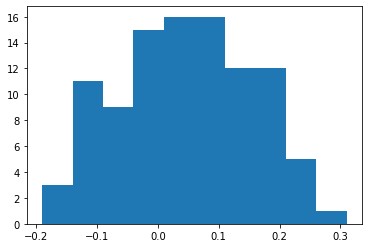

In [9]:
plt.hist(ls)
plt.show()

In [10]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.04920000000000003


### Counterfactual fairness

P(two_year_recid race=0 = 1 | race = 1, two_year_recid = 0)

In [11]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in tqdm.tqdm(range(100)):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        s = trace.nodes['sex']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['priors_count']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(0)})
        counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]

100%|██████████| 100/100 [00:02<00:00, 34.62it/s]


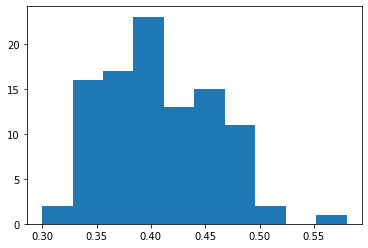

In [12]:
plt.hist(ls) 
plt.show()

In [13]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.4078000000000001


### Average Total Effect

In [14]:
# E(Y|do(X=1))−E(Y|do(X=0)).
e1_samples = [pyro.do(model, data={'race': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(model, data={'race': torch.tensor(0)})() for _ in range(1000)]
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)
e1_avg - e2_avg

-0.02699999999999997

### Natural Effects

#### Natural Direct Effects

In [15]:
# When Z = 1 E(Y|(M = 1), do(X = 1)) - E(Y|(M = 1), do(X = 0))
cond_model = pyro.condition(model, data={'priors_count': torch.tensor(0)})
e1_samples = [pyro.do(cond_model, data={'race': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'race': torch.tensor(0)})() for _ in range(1000)]

In [16]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [17]:
e1_avg

0.329

In [18]:
e2_avg

0.328

In [19]:
e1_avg - e2_avg

0.0010000000000000009

#### Natural Indirect Effect

In [20]:
# When Z = 1 E(Y|(X = 1), do(M = 1)) - E(Y|(X = 1), do(M = 0))
cond_model = pyro.condition(model, data={'race': torch.tensor(1)})
e1_samples = [pyro.do(cond_model, data={'priors_count': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'priors_count': torch.tensor(0)})() for _ in range(1000)]

In [21]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [22]:
e1_avg - e2_avg

0.25599999999999995

### Necessity and Sufficienty

#### Necessity

$P_{necessity} = P(Y_{X=0} = 0 | X=1, Y=1)$

In [23]:
cond_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(1)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_necessities = []
for _ in range(1000):
    trace = posterior()
    s = trace.nodes['sex']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['priors_count']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(0)})
    counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_necessities.append(float(trace.nodes['two_year_recid']['value']))

In [24]:
p_necessity = 1 - mean(p_necessities)
print("P necessity =", p_necessity)

P necessity = 0.534


#### Sufficiency

In [25]:
cond_model = pyro.condition(model, data = {"race": torch.tensor(0), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_sufficiencies = []
for _ in range(1000):
    trace = posterior()
    s = trace.nodes['sex']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['priors_count']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(1)})
    counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_sufficiencies.append(float(trace.nodes['two_year_recid']['value']))

In [26]:
p_sufficiency = mean(p_sufficiencies)
print("P necessity =", p_sufficiency)

P necessity = 0.48


## Model 1 - b) Analysis by Gender

### TP vs FN Rate

In [28]:
df = pd.read_csv(data_file_path)

truth = []
preds = []
num_sample = 10
for index, row in df.iterrows():
    r = race_alias.index( row['race'] ) 
    s = sex_alias.index( row['sex'] ) 
    a = age_cat_alias.index( row['age_cat'] ) 
    c = priors_count_alias.index( row['priors_count'] ) 
    t = two_year_recid_alias.index( row['two_year_recid'] ) 
    conditioned_model = pyro.condition(model, data = {"race": torch.tensor( r ),
                                                      "sex": torch.tensor( s ),
                                                      "age_cat": torch.tensor( a ),
                                                      "priors_count": torch.tensor( c )
                                                     })
    posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
    trace = posterior()
    pred = int(trace.nodes['two_year_recid']['value'])
    truth += [ conditioned_model() ]
    preds += [ pred ]
    if ((index%500)==0):print(index//500)
truth = np.array(truth)
preds = np.array(preds)

# score for male defendants
y_test_ = truth[ df['sex']=='Male' ]
y_pred_ = preds[ df['sex']=='Male' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("False positive rate (Male)      : ", fp/(fp+tn))
print("False negative rate (Male)      : ", fn/(fn+tp))
print("Accuracy (Male)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (Male)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_male = fp/(fp+tn)
fnr_male =  fn/(fn+tp)

# score for White defendants
y_test_ = truth[ df['sex']=='Female' ]
y_pred_ = preds[ df['sex']=='Female' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("\nFalse positive rate (Female)      : ", fp/(fp+tn))
print("False negative rate (Female)      : ", fn/(fn+tp))
print("Accuracy (White)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (White)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_female = fp/(fp+tn)
fnr_female =  fn/(fn+tp)

print('\nFalse positive rate Gap:', abs(fpr_male-fpr_female))
print('False negative rate Gap:', abs(fnr_male-fnr_female))

0
1
2
3
4
5
6
7
8
9
10
11
12
False positive rate (Male)      :  0.4540519581233036
False negative rate (Male)      :  0.5114795918367347
Accuracy (Male)      :   0.5185560738186981
AUC (Male)      :   0.5172342250199808

False positive rate (Female)      :  0.4263456090651558
False negative rate (Female)      :  0.49902534113060426
Accuracy (White)      :   0.5430680885972108
AUC (White)      :   0.53731452490212

False positive rate Gap: 0.02770634905814784
False negative rate Gap: 0.012454250706130487


### Intervention
P(two_year_recid=1 | do(sex=1)) - P(two_year_recid=1 | do(sex=0))

In [29]:
ls = []
for run in tqdm.tqdm(range(100)):
    num_sample = 100
    P_y1_do = {}
    for x in [0,1]:
        do_model = pyro.do(model, data={ 'sex': torch.tensor( x )  })
        posterior = pyro.infer.Importance(do_model, num_samples=num_sample).run()
        marginal = pyro.infer.EmpiricalMarginal(posterior, "two_year_recid") 
        samples = np.array([marginal().item() for _ in range(num_sample)])
        e_unique, e_counts = np.unique(samples, return_counts=True)
        dic = dict( zip(e_unique, e_counts) )
        P_y1_do[ x ] = dic[ 1 ] / num_sample
    diff = P_y1_do[0] - P_y1_do[1]
    ls += [ diff ]

100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


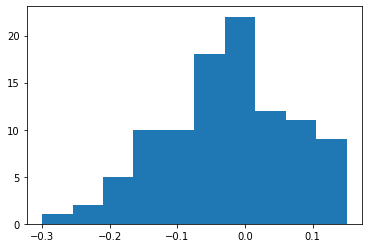

In [30]:
plt.hist(ls)
plt.show()

In [31]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

-0.023600000000000003


### Counterfactual fairness

P(two_year_recid sex=0 = 1 | sex = 1, two_year_recid = 0)

In [32]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"sex": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in tqdm.tqdm(range(100)):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        r = trace.nodes['race']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['priors_count']['value']
        do_model = pyro.do(model, data = {"sex": torch.tensor(0)})
        counterfactual_model = pyro.condition(do_model, data = {'race': r,'age_cat': a, 'priors_count': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]

100%|██████████| 100/100 [00:02<00:00, 37.15it/s]


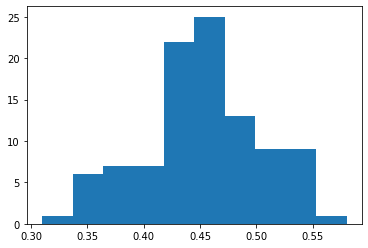

In [33]:
plt.hist(ls) 
plt.show()

In [34]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.45080000000000015


### Average Total Effect

In [35]:
# E(Y|do(X=1))−E(Y|do(X=0)).
e1_samples = [pyro.do(model, data={'sex': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(model, data={'sex': torch.tensor(0)})() for _ in range(1000)]
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)
e1_avg - e2_avg

-0.006000000000000005

### Natural Effects

#### Natural Direct Effects

In [36]:
# When Z = 1 E(Y|(M = 1), do(X = 1)) - E(Y|(M = 1), do(X = 0))
cond_model = pyro.condition(model, data={'priors_count': torch.tensor(0)})
e1_samples = [pyro.do(cond_model, data={'sex': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'sex': torch.tensor(0)})() for _ in range(1000)]

In [37]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [38]:
e1_avg

0.337

In [39]:
e2_avg

0.337

In [40]:
e1_avg - e2_avg

0.0

#### Natural Indirect Effect

In [41]:
# When Z = 1 E(Y|(X = 1), do(M = 1)) - E(Y|(X = 1), do(M = 0))
cond_model = pyro.condition(model, data={'sex': torch.tensor(1)})
e1_samples = [pyro.do(cond_model, data={'priors_count': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'priors_count': torch.tensor(0)})() for _ in range(1000)]

In [42]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [43]:
e1_avg - e2_avg

0.24299999999999994

### Necessity and Sufficienty

#### Necessity

$P_{necessity} = P(Y_{X=0} = 0 | X=1, Y=1)$

In [44]:
cond_model = pyro.condition(model, data = {"sex": torch.tensor(1), "two_year_recid": torch.tensor(1)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_necessities = []
for _ in range(1000):
    trace = posterior()
    r = trace.nodes['race']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['priors_count']['value']
    do_model = pyro.do(model, data = {"sex": torch.tensor(0)})
    counterfactual_model = pyro.condition(do_model, data = {'race': r,'age_cat': a, 'priors_count': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_necessities.append(float(trace.nodes['two_year_recid']['value']))

In [45]:
p_necessity = 1 - mean(p_necessities)
print("P necessity =", p_necessity)

P necessity = 0.469


#### Sufficiency

In [46]:
cond_model = pyro.condition(model, data = {"sex": torch.tensor(0), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_sufficiencies = []
for _ in range(1000):
    trace = posterior()
    r = trace.nodes['race']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['priors_count']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(1)})
    counterfactual_model = pyro.condition(do_model, data = {'race': r,'age_cat': a, 'priors_count': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_sufficiencies.append(float(trace.nodes['two_year_recid']['value']))

In [47]:
p_sufficiency = mean(p_sufficiencies)
print("P necessity =", p_sufficiency)

P necessity = 0.393


## Model 1 -  c) Analysis by Race + Gender

### TP vs FN Rate

In [120]:
df = pd.read_csv(data_file_path)

truth = []
preds = []
num_sample = 10
for index, row in df.iterrows():
    r = race_alias.index( row['race'] ) 
    s = sex_alias.index( row['sex'] ) 
    a = age_cat_alias.index( row['age_cat'] ) 
    c = priors_count_alias.index( row['priors_count'] ) 
    t = two_year_recid_alias.index( row['two_year_recid'] ) 
    conditioned_model = pyro.condition(model, data = {"race": torch.tensor( r ),
                                                      "sex": torch.tensor( s ),
                                                      "age_cat": torch.tensor( a ),
                                                      "priors_count": torch.tensor( c )
                                                     })
    posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
    trace = posterior()
    pred = int(trace.nodes['two_year_recid']['value'])
    truth += [ conditioned_model() ]
    preds += [ pred ]
    if ((index%500)==0):print(index//500)
truth = np.array(truth)
preds = np.array(preds)

## all scores for black defendants
# score for black and male defendants
y_test_ = truth[(df['race']=='African-American') & (df['sex']=='Male') ]
y_pred_ = preds[(df['race']=='African-American') & (df['sex']=='Male')]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("False positive rate (African-American and Male)      : ", fp/(fp+tn))
print("False negative rate (African-American and Male)      : ", fn/(fn+tp))
print("Accuracy (African-American and Male)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (African-American and Male)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_black_male = fp/(fp+tn)
fnr_black_male =  fn/(fn+tp)

print('')
# score for black and female defendants
y_test_ = truth[(df['race']=='African-American') & (df['sex']=='Female')]
y_pred_ = preds[(df['race']=='African-American') & (df['sex']=='Female')]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("\nFalse positive rate (African-American and Female)      : ", fp/(fp+tn))
print("False negative rate (African-American and Female)      : ", fn/(fn+tp))
print("Accuracy (African-American and Female)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (African-American and Female)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_black_female = fp/(fp+tn)
fnr_black_female =  fn/(fn+tp)

## all scores for white defendants
print('')
# scores for white and male defendants
y_test_ = truth[(df['race']=='Caucasian') & (df['sex']=='Male') ]
y_pred_ = preds[(df['race']=='Caucasian') & (df['sex']=='Male')]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("False positive rate (Caucasian and Male)      : ", fp/(fp+tn))
print("False negative rate (Caucasian and Male)      : ", fn/(fn+tp))
print("Accuracy (Caucasian and Male)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (Caucasian and Male)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_white_male = fp/(fp+tn)
fnr_white_male =  fn/(fn+tp)

print('')
# scores for white and female defendants
y_test_ = truth[(df['race']=='Caucasian') & (df['sex']=='Female') ]
y_pred_ = preds[(df['race']=='Caucasian') & (df['sex']=='Female')]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("False positive rate (Caucasian and Female)      : ", fp/(fp+tn))
print("False negative rate (Caucasian and Female)      : ", fn/(fn+tp))
print("Accuracy (Caucasian and Female)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (Caucasian and Female)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_white_female = fp/(fp+tn)
fnr_white_female =  fn/(fn+tp)

### calculate gaps
## race gap with same gender
# African-American versus Caucasian Males
print('\nFalse positive rate Gap across African-American versus Caucasian Males:', abs(fpr_black_male-fpr_white_male))
print('False negative rate Gap across African-American versus Caucasian Males:', abs(fnr_black_male-fnr_white_male))
# African-American versus Caucasian Female
print('\nFalse positive rate Gap across African-American versus Caucasian Females:', abs(fpr_black_female-fpr_white_female))
print('False negative rate Gap across African-American versus Caucasian Females:', abs(fnr_black_female-fnr_white_female))
## race gap versus different gender
# African-American Male versus Caucasian Female
print('\nFalse positive rate Gap across African-American Male versus Caucasian Female:', abs(fpr_black_male-fpr_white_female))
print('False negative rate Gap across African-American Male versus Caucasian Female:', abs(fnr_black_male-fnr_white_female))
# African-American Female versus Caucasian Male
print('\nFalse positive rate Gap across African-American Female versus Caucasian Male:', abs(fpr_black_female-fpr_white_male))
print('False negative rate Gap across African-American Female versus Caucasian Male:', abs(fnr_black_female-fnr_white_male))


0
1
2
3
4
5
6
7
8
9
10
11
12
False positive rate (African-American and Male)      :  0.5098438560760353
False negative rate (African-American and Male)      :  0.4449395289624443
Accuracy (African-American and Male)      :   0.5236530880420499
AUC (African-American and Male)      :   0.5226083074807603


False positive rate (African-American and Female)      :  0.4179566563467492
False negative rate (African-American and Female)      :  0.5197568389057751
Accuracy (African-American and Female)      :   0.5306748466257669
AUC (African-American and Female)      :   0.5311432523737379

False positive rate (Caucasian and Male)      :  0.3811188811188811
False negative rate (Caucasian and Male)      :  0.5652759084791387
Accuracy (Caucasian and Male)      :   0.5463698993110758
AUC (Caucasian and Male)      :   0.5268026052009902

False positive rate (Caucasian and Female)      :  0.3305785123966942
False negative rate (Caucasian and Female)      :  0.6176470588235294
Accuracy (Caucasian an

### Intervention
P(two_year_recid=1 | do(sex=1)) - P(two_year_recid=1 | do(sex=0))

In [128]:
#for race in [0, 1]: # can either/and condition on race, and/or do an intevention to compare both different races and gender combinations

ls = []
for run in tqdm.tqdm(range(100)):
    num_sample = 100
    P_y1_do = {}
    for x in [0,1]:
        do_model = pyro.do(model, data={ 'sex': torch.tensor( x )
                                       # ,'race': torch.tensor(race)
                                       })
        posterior = pyro.infer.Importance(do_model, num_samples=num_sample).run()
        marginal = pyro.infer.EmpiricalMarginal(posterior, "two_year_recid") 
        samples = np.array([marginal().item() for _ in range(num_sample)])
        e_unique, e_counts = np.unique(samples, return_counts=True)
        dic = dict( zip(e_unique, e_counts) )
        P_y1_do[ x ] = dic[ 1 ] / num_sample
    diff = P_y1_do[0] - P_y1_do[1]
    ls += [ diff ]

100%|██████████| 100/100 [00:22<00:00,  4.39it/s]

-0.014299999999999997


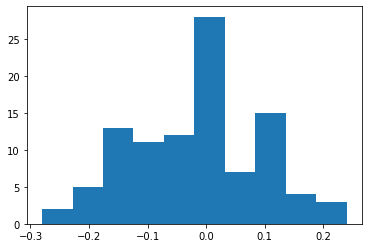

In [129]:
plt.hist(ls)
plt.show()

In [130]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

-0.014299999999999997


### Counterfactual fairness

P(two_year_recid sex=0 = 1 | sex = 1, two_year_recid = 0)

In [32]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"sex": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in tqdm.tqdm(range(100)):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        r = trace.nodes['race']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['priors_count']['value']
        do_model = pyro.do(model, data = {"sex": torch.tensor(0)})
        counterfactual_model = pyro.condition(do_model, data = {'race': r,'age_cat': a, 'priors_count': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]

100%|██████████| 100/100 [00:02<00:00, 37.15it/s]


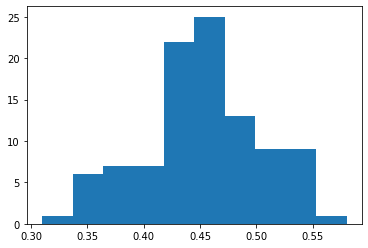

In [33]:
plt.hist(ls) 
plt.show()

In [34]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.45080000000000015


### Average Total Effect

In [35]:
# E(Y|do(X=1))−E(Y|do(X=0)).
e1_samples = [pyro.do(model, data={'sex': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(model, data={'sex': torch.tensor(0)})() for _ in range(1000)]
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)
e1_avg - e2_avg

-0.006000000000000005

### Natural Effects

#### Natural Direct Effects

In [36]:
# When Z = 1 E(Y|(M = 1), do(X = 1)) - E(Y|(M = 1), do(X = 0))
cond_model = pyro.condition(model, data={'priors_count': torch.tensor(0)})
e1_samples = [pyro.do(cond_model, data={'sex': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'sex': torch.tensor(0)})() for _ in range(1000)]

In [37]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [38]:
e1_avg

0.337

In [39]:
e2_avg

0.337

In [40]:
e1_avg - e2_avg

0.0

#### Natural Indirect Effect

In [41]:
# When Z = 1 E(Y|(X = 1), do(M = 1)) - E(Y|(X = 1), do(M = 0))
cond_model = pyro.condition(model, data={'sex': torch.tensor(1)})
e1_samples = [pyro.do(cond_model, data={'priors_count': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'priors_count': torch.tensor(0)})() for _ in range(1000)]

In [42]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [43]:
e1_avg - e2_avg

0.24299999999999994

### Necessity and Sufficienty

#### Necessity

$P_{necessity} = P(Y_{X=0} = 0 | X=1, Y=1)$

In [44]:
cond_model = pyro.condition(model, data = {"sex": torch.tensor(1), "two_year_recid": torch.tensor(1)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_necessities = []
for _ in range(1000):
    trace = posterior()
    r = trace.nodes['race']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['priors_count']['value']
    do_model = pyro.do(model, data = {"sex": torch.tensor(0)})
    counterfactual_model = pyro.condition(do_model, data = {'race': r,'age_cat': a, 'priors_count': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_necessities.append(float(trace.nodes['two_year_recid']['value']))

In [45]:
p_necessity = 1 - mean(p_necessities)
print("P necessity =", p_necessity)

P necessity = 0.469


#### Sufficiency

In [46]:
cond_model = pyro.condition(model, data = {"sex": torch.tensor(0), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_sufficiencies = []
for _ in range(1000):
    trace = posterior()
    r = trace.nodes['race']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['priors_count']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(1)})
    counterfactual_model = pyro.condition(do_model, data = {'race': r,'age_cat': a, 'priors_count': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_sufficiencies.append(float(trace.nodes['two_year_recid']['value']))

In [47]:
p_sufficiency = mean(p_sufficiencies)
print("P necessity =", p_sufficiency)

P necessity = 0.393


## Model 2 - Direct Race Path

### Read Model Parameters

In [99]:
# race
df = pd.read_csv('data/model2_race.csv')
race_alias = list(df['Var1'])
race_prob = torch.tensor(list(df['Freq']) )

# sex
df = pd.read_csv('data/model2_sex.csv')
sex_alias = list(df['Var1'])
sex_prob = torch.tensor(list(df['Freq']) )

# age_cat
df = pd.read_csv('data/model2_age_cat.csv')
age_cat_alias = list(df['Var1'])
age_cat_prob = torch.tensor(list(df['Freq']) )

# priors_count
df = pd.read_csv('data/model2_priors_count.csv')
priors_count_alias = list(set( df['priors_count'] ))

dic = {}
for index, row in df.iterrows():
    dic[(row['race'], row['sex'],row['age_cat'],row['priors_count'])] = row['Freq']
l0 = []
for r in race_alias:
    l1 = []
    for s in sex_alias:
        l2 = []
        for a in age_cat_alias:
            l3 = []
            for c in priors_count_alias:            
                l3 += [ dic[r,s,a,c] ]
            l2 +=  [ l3 ]
        l1 += [ l2 ]
    l0 += [ l1 ]

priors_count_probs = torch.tensor( l0 )

# two_year_recid
df = pd.read_csv('data/model2_two_year_recid.csv')
two_year_recid_alias = list(set( df['two_year_recid'] ))

dic = {}
for index, row in df.iterrows():
    dic[(row['race'], row['priors_count'],row['two_year_recid'])] = row['Freq']
    
l0 = []
for r in race_alias:
    l1 = []
    for c in priors_count_alias:
        l2 = []
        for t in two_year_recid_alias:
            l2 += [ dic[r,c,t] ]
        l1 += [ l2 ]
    l0 += [ l1 ]

two_year_recid_probs = torch.tensor( l0 )

### Define model

In [100]:
def model():
    race = pyro.sample("race", dist.Categorical( race_prob )) 
    sex = pyro.sample("sex", dist.Categorical( sex_prob )) 
    age_cat = pyro.sample("age_cat", dist.Categorical( age_cat_prob )) 
    priors_count = pyro.sample("priors_count", dist.Categorical(priors_count_probs[race][sex][age_cat]))
    two_year_recid = pyro.sample("two_year_recid", dist.Categorical(two_year_recid_probs[race][priors_count]))
    return two_year_recid

In [50]:
df = pd.read_csv(data_file_path)

truth = []
preds = []
num_sample = 10
for index, row in df.iterrows():
    r = race_alias.index( row['race'] ) 
    s = sex_alias.index( row['sex'] ) 
    a = age_cat_alias.index( row['age_cat'] ) 
    c = priors_count_alias.index( row['priors_count'] ) 
    t = two_year_recid_alias.index( row['two_year_recid'] ) 
    conditioned_model = pyro.condition(model, data = {"race": torch.tensor( r ),
                                                      "sex": torch.tensor( s ),
                                                      "age_cat": torch.tensor( a ),
                                                      "priors_count": torch.tensor( c )
                                                     })
    posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
    trace = posterior()
    pred = int(trace.nodes['two_year_recid']['value'])
    truth += [ conditioned_model() ]
    preds += [ pred ]
    if ((index%500)==0):print(index//500)
truth = np.array(truth)
preds = np.array(preds)

# score for Black defendants
y_test_ = truth[ df['race']=='African-American' ]
y_pred_ = preds[ df['race']=='African-American' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("False positive rate (Black)      : ", fp/(fp+tn))
print("False negative rate (Black)      : ", fn/(fn+tp))
print("Accuracy (Black)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (Black)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_black = fp/(fp+tn)
fnr_black =  fn/(fn+tp)

# score for White defendants
y_test_ = truth[ df['race']=='Caucasian' ]
y_pred_ = preds[ df['race']=='Caucasian' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("\nFalse positive rate (White)      : ", fp/(fp+tn))
print("False negative rate (White)      : ", fn/(fn+tp))
print("Accuracy (White)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (White)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_white = fp/(fp+tn)
fnr_white =  fn/(fn+tp)

print('\nFalse positive rate Gap:', abs(fpr_black-fpr_white))
print('False negative rate Gap:', abs(fnr_black-fnr_white))

0
1
2
3
4
5
6
7
8
9
10
11
12
False positive rate (Black)      :  0.47543668122270744
False negative rate (Black)      :  0.47263948497854075
Accuracy (Black)      :   0.525974025974026
AUC (Black)      :   0.5259619168993759

False positive rate (White)      :  0.38065843621399176
False negative rate (White)      :  0.5461847389558233
Accuracy (White)      :   0.552159739201304
AUC (White)      :   0.5365784124150924

False positive rate Gap: 0.09477824500871568
False negative rate Gap: 0.07354525397728257


### Intervention

You are interested in the average causal effect P(two_year_recid = 1|do(race = 0)) − P(two_year_recid = 1|do(race = 1)),
where two_year_recid=1 represents recidivism, 
race=0 represents "African-American" 
race=1 represents "Caucasian" 

In [51]:
ls = []
for run in tqdm.tqdm(range(100)):
    num_sample = 100
    P_y1_do = {}
    for x in [0,1]:
        do_model = pyro.do(model, data={ 'race': torch.tensor( x )  })
        posterior = pyro.infer.Importance(do_model, num_samples=num_sample).run()
        marginal = pyro.infer.EmpiricalMarginal(posterior, "two_year_recid") 
        samples = np.array([marginal().item() for _ in range(num_sample)])
        e_unique, e_counts = np.unique(samples, return_counts=True)
        dic = dict( zip(e_unique, e_counts) )
        P_y1_do[ x ] = dic[ 1 ] / num_sample
    diff = P_y1_do[0] - P_y1_do[1]
    ls += [ diff ]

100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


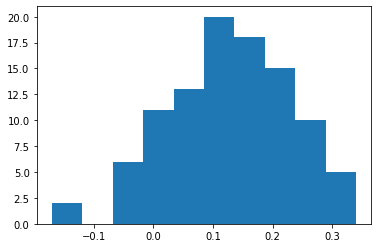

In [52]:
plt.hist(ls) 
plt.show()

In [53]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.129


### Counterfactual fairness

In [54]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in tqdm.tqdm(range(100)):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        s = trace.nodes['sex']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['priors_count']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(0)})
        counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]

100%|██████████| 100/100 [00:02<00:00, 35.00it/s]


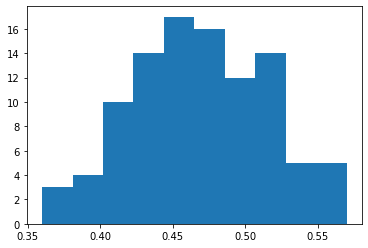

In [55]:
plt.hist(ls)
plt.show()

In [56]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.4687000000000001


### Average Total Effects

In [101]:
# E(Y|do(X=1))−E(Y|do(X=0)).
e1_samples = [pyro.do(model, data={'race': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(model, data={'race': torch.tensor(0)})() for _ in range(1000)]
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)
e1_avg - e2_avg

-0.14400000000000002

### Natural effects

#### Natural Direct Effects

In [102]:
# When Z = 1 E(Y|(M = 1), do(X = 1)) - E(Y|(M = 1), do(X = 0))
cond_model = pyro.condition(model, data={'priors_count': torch.tensor(0)})
e1_samples = [pyro.do(cond_model, data={'race': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'race': torch.tensor(0)})() for _ in range(1000)]

In [103]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [104]:
e1_avg

0.291

In [105]:
e2_avg

0.375

In [106]:
e1_avg - e2_avg

-0.08400000000000002

#### Natural Indirect Effects

In [107]:
# NIE = E(Y | M=1, do(X=0)) – E(Y | M=0, do(X=0))
cond_model_1 = pyro.condition(model, data={'priors_count': torch.tensor(1)})
cond_model_2 = pyro.condition(model, data={'priors_count': torch.tensor(0)})
e1_samples = [pyro.do(cond_model_1, data={'race': torch.tensor(0)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model_2, data={'race': torch.tensor(0)})() for _ in range(1000)]

In [108]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [109]:
e1_avg - e2_avg

0.246

### Necessity and Sufficienty

#### Necessity

$P_{necessity} = P(Y_{X=0} = 0 | X=1, Y=1)$

In [110]:
cond_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(1)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_necessities = []
for _ in range(1000):
    trace = posterior()
    s = trace.nodes['sex']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['priors_count']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(0)})
    counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_necessities.append(float(trace.nodes['two_year_recid']['value']))

In [111]:
p_necessity = 1 - mean(p_necessities)
print("P necessity =", p_necessity)

P necessity = 0.514


#### Sufficiency

In [112]:
cond_model = pyro.condition(model, data = {"race": torch.tensor(0), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_sufficiencies = []
for _ in range(1000):
    trace = posterior()
    s = trace.nodes['sex']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['priors_count']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(1)})
    counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_sufficiencies.append(float(trace.nodes['two_year_recid']['value']))

In [113]:
p_sufficiency = mean(p_sufficiencies)
print("P necessity =", p_sufficiency)

P necessity = 0.391


## Model 3 - Unaware by Race

### Read data

In [70]:
# race
df = pd.read_csv('data/model3_race.csv')
race_alias = list(df['Var1'])
race_prob = torch.tensor(list(df['Freq']) )

# sex
df = pd.read_csv('data/model3_sex.csv')
sex_alias = list(df['Var1'])
sex_prob = torch.tensor(list(df['Freq']) )

# age_cat
df = pd.read_csv('data/model3_age_cat.csv')
age_cat_alias = list(df['Var1'])
age_cat_prob = torch.tensor(list(df['Freq']) )

# priors_count
df = pd.read_csv('data/model3_priors_count.csv')
priors_count_alias = list(set( df['priors_count'] ))

dic = {}
for index, row in df.iterrows():
    dic[( row['sex'],row['age_cat'],row['priors_count'])] = row['Freq']
l1 = []
for s in sex_alias:
    l2 = []
    for a in age_cat_alias:
        l3 = []
        for c in priors_count_alias:            
            l3 += [ dic[s,a,c] ]
        l2 +=  [ l3 ]
    l1 += [ l2 ]

priors_count_probs = torch.tensor( l1 )

# two_year_recid
df = pd.read_csv('data/model3_two_year_recid.csv')
two_year_recid_alias = list(df['Unnamed: 0'])

l = []
for e in priors_count_alias:
    l += [ list( df[e] )  ]
two_year_recid_probs = torch.tensor( l )

### Define model

In [71]:
def model():
    race = pyro.sample("race", dist.Categorical( race_prob )) 
    sex = pyro.sample("sex", dist.Categorical( sex_prob )) 
    age_cat = pyro.sample("age_cat", dist.Categorical( age_cat_prob )) 
    priors_count = pyro.sample("priors_count", dist.Categorical(priors_count_probs[sex][age_cat]))
    two_year_recid = pyro.sample("two_year_recid", dist.Categorical(two_year_recid_probs[priors_count]))
    return two_year_recid


### Association

In [72]:
df = pd.read_csv(data_file_path)

truth = []
preds = []
num_sample = 10
for index, row in df.iterrows():
    r = race_alias.index( row['race'] ) 
    s = sex_alias.index( row['sex'] ) 
    a = age_cat_alias.index( row['age_cat'] ) 
    c = priors_count_alias.index( row['priors_count'] ) 
    t = two_year_recid_alias.index( row['two_year_recid'] ) 
    conditioned_model = pyro.condition(model, data = {"race": torch.tensor( r ),
                                                      "sex": torch.tensor( s ),
                                                      "age_cat": torch.tensor( a ),
                                                      "priors_count": torch.tensor( c )
                                                     })
    posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
    trace = posterior()
    pred = int(trace.nodes['two_year_recid']['value'])
    truth += [ conditioned_model() ]
    preds += [ pred ]
    if ((index%500)==0):print(index//500)
truth = np.array(truth)
preds = np.array(preds)

# score for Black defendants
y_test_ = truth[ df['race']=='African-American' ]
y_pred_ = preds[ df['race']=='African-American' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("False positive rate (Black)      : ", fp/(fp+tn))
print("False negative rate (Black)      : ", fn/(fn+tp))
print("Accuracy (Black)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (Black)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_black = fp/(fp+tn)
fnr_black =  fn/(fn+tp)

# score for White defendants
y_test_ = truth[ df['race']=='Caucasian' ]
y_pred_ = preds[ df['race']=='Caucasian' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("\nFalse positive rate (White)      : ", fp/(fp+tn))
print("False negative rate (White)      : ", fn/(fn+tp))
print("Accuracy (White)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (White)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_white = fp/(fp+tn)
fnr_white =  fn/(fn+tp)

print('\nFalse positive rate Gap:', abs(fpr_black-fpr_white))
print('False negative rate Gap:', abs(fnr_black-fnr_white))

0
1
2
3
4
5
6
7
8
9
10
11
12
False positive rate (Black)      :  0.4654639175257732
False negative rate (Black)      :  0.484624145785877
Accuracy (Black)      :   0.5254329004329005
AUC (Black)      :   0.5249559683441749

False positive rate (White)      :  0.422962962962963
False negative rate (White)      :  0.5443840579710145
Accuracy (White)      :   0.5224123879380603
AUC (White)      :   0.5163264895330113

False positive rate Gap: 0.04250095456281022
False negative rate Gap: 0.05975991218513754


### Intervention

In [73]:
# You are interested in the average causal effect P(two_year_recid = 1|do(race = 0)) − P(two_year_recid = 1|do(race = 1)),
# where two_year_recid=1 represents recidivism, 
# race=0 represents "African-American" 
# race=0 represents "Caucasian" 

In [74]:
ls = []
for run in tqdm.tqdm(range(100)):
    num_sample = 100
    P_y1_do = {}
    for x in [0,1]:
        do_model = pyro.do(model, data={ 'race': torch.tensor( x )  })
        posterior = pyro.infer.Importance(do_model, num_samples=num_sample).run()
        marginal = pyro.infer.EmpiricalMarginal(posterior, "two_year_recid") 
        samples = np.array([marginal().item() for _ in range(num_sample)])
        e_unique, e_counts = np.unique(samples, return_counts=True)
        dic = dict( zip(e_unique, e_counts) )
        P_y1_do[ x ] = dic[ 1 ] / num_sample
    diff = P_y1_do[0] - P_y1_do[1]
    ls += [ diff ]

100%|██████████| 100/100 [00:22<00:00,  4.43it/s]


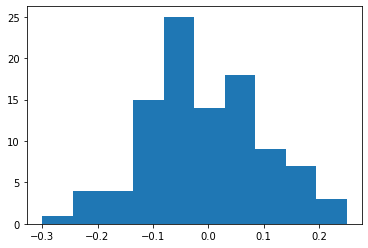

In [75]:
plt.hist(ls)
plt.show()

In [76]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

-0.0108


### Counterfactual fairness

In [77]:
# P(two_year_recid race=0 = 1|race = 1,two_year_recid = 0)

In [78]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in tqdm.tqdm(range(100)):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        s = trace.nodes['sex']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['priors_count']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(0)})
        counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]

100%|██████████| 100/100 [00:02<00:00, 36.73it/s]


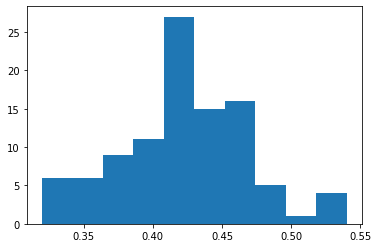

In [79]:
plt.hist(ls)
plt.show()

In [80]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.4237000000000002


In [81]:
# P(two_year_recid race=1 = 1|race = 0,two_year_recid = 1)

In [82]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"race": torch.tensor(0), "two_year_recid": torch.tensor(1)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in tqdm.tqdm(range(100)):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        s = trace.nodes['sex']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['priors_count']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(1)})
        counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]

100%|██████████| 100/100 [00:02<00:00, 36.93it/s]


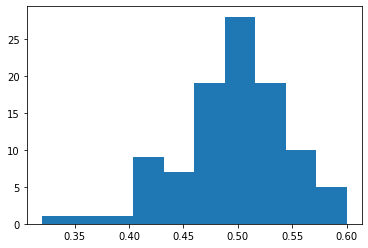

In [83]:
plt.hist(ls)
plt.show()

In [84]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.49420000000000014


### Average Total Effects

In [85]:
# E(Y|do(X=1))−E(Y|do(X=0)).
e1_samples = [pyro.do(model, data={'race': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(model, data={'race': torch.tensor(0)})() for _ in range(1000)]
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)
e1_avg - e2_avg

-0.021999999999999964

### Natural effects

#### Natural Direct Effects

In [86]:
# When Z = 1 E(Y|(M = 1), do(X = 1)) - E(Y|(M = 1), do(X = 0))
cond_model = pyro.condition(model, data={'priors_count': torch.tensor(0)})
e1_samples = [pyro.do(cond_model, data={'race': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'race': torch.tensor(0)})() for _ in range(1000)]

In [87]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [88]:
e1_avg

0.308

In [89]:
e2_avg

0.328

In [90]:
e1_avg - e2_avg

-0.020000000000000018

#### Natural Indirect Effects

In [91]:
# NIE = E(Y | M=1, do(X=0)) – E(Y | M=0, do(X=0))
cond_model_1 = pyro.condition(model, data={'priors_count': torch.tensor(1)})
cond_model_2 = pyro.condition(model, data={'priors_count': torch.tensor(0)})
e1_samples = [pyro.do(cond_model_1, data={'race': torch.tensor(0)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model_2, data={'race': torch.tensor(0)})() for _ in range(1000)]

In [92]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [93]:
e1_avg - e2_avg

0.26099999999999995

### Necessity and Sufficienty

#### Necessity

$P_{necessity} = P(Y_{X=0} = 0 | X=1, Y=1)$

In [94]:
cond_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(1)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_necessities = []
for _ in range(1000):
    trace = posterior()
    s = trace.nodes['sex']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['priors_count']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(0)})
    counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_necessities.append(float(trace.nodes['two_year_recid']['value']))

In [95]:
p_necessity = 1 - mean(p_necessities)
print("P necessity =", p_necessity)

P necessity = 0.5


#### Sufficiency

In [96]:
cond_model = pyro.condition(model, data = {"race": torch.tensor(0), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_sufficiencies = []
for _ in range(1000):
    trace = posterior()
    s = trace.nodes['sex']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['priors_count']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(1)})
    counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_sufficiencies.append(float(trace.nodes['two_year_recid']['value']))

In [97]:
p_sufficiency = mean(p_sufficiencies)
print("P necessity =", p_sufficiency)

P necessity = 0.403


## Model 4 - Direct by Gender, and Indirect by Race + Gender

### Read Model Parameters

In [134]:
# race
df = pd.read_csv('data/model4_race.csv')
race_alias = list(df['Var1'])
race_prob = torch.tensor(list(df['Freq']) )

# sex
df = pd.read_csv('data/model4_sex.csv')
sex_alias = list(df['Var1'])
sex_prob = torch.tensor(list(df['Freq']) )

# age_cat
df = pd.read_csv('data/model4_age_cat.csv')
age_cat_alias = list(df['Var1'])
age_cat_prob = torch.tensor(list(df['Freq']) )

# priors_count
df = pd.read_csv('data/model4_priors_count.csv')
priors_count_alias = list(set( df['priors_count'] ))

dic = {}
for index, row in df.iterrows():
    dic[(row['race'], row['sex'],row['age_cat'],row['priors_count'])] = row['Freq']
l0 = []
for r in race_alias:
    l1 = []
    for s in sex_alias:
        l2 = []
        for a in age_cat_alias:
            l3 = []
            for c in priors_count_alias:            
                l3 += [ dic[r,s,a,c] ]
            l2 +=  [ l3 ]
        l1 += [ l2 ]
    l0 += [ l1 ]

priors_count_probs = torch.tensor( l0 )

# two_year_recid
df = pd.read_csv('data/model4_two_year_recid.csv')
two_year_recid_alias = list(set( df['two_year_recid'] ))

dic = {}
for index, row in df.iterrows():
    dic[(row['race'], row['priors_count'],row['two_year_recid'])] = row['Freq']
    
l0 = []
for r in race_alias:
    l1 = []
    for c in priors_count_alias:
        l2 = []
        for t in two_year_recid_alias:
            l2 += [ dic[r,c,t] ]
        l1 += [ l2 ]
    l0 += [ l1 ]

two_year_recid_probs = torch.tensor( l0 )

KeyError: 'race'

### Define model

In [100]:
def model():
    race = pyro.sample("race", dist.Categorical( race_prob )) 
    sex = pyro.sample("sex", dist.Categorical( sex_prob )) 
    age_cat = pyro.sample("age_cat", dist.Categorical( age_cat_prob )) 
    priors_count = pyro.sample("priors_count", dist.Categorical(priors_count_probs[race][sex][age_cat]))
    two_year_recid = pyro.sample("two_year_recid", dist.Categorical(two_year_recid_probs[race][priors_count]))
    return two_year_recid

In [50]:
df = pd.read_csv(data_file_path)

truth = []
preds = []
num_sample = 10
for index, row in df.iterrows():
    r = race_alias.index( row['race'] ) 
    s = sex_alias.index( row['sex'] ) 
    a = age_cat_alias.index( row['age_cat'] ) 
    c = priors_count_alias.index( row['priors_count'] ) 
    t = two_year_recid_alias.index( row['two_year_recid'] ) 
    conditioned_model = pyro.condition(model, data = {"race": torch.tensor( r ),
                                                      "sex": torch.tensor( s ),
                                                      "age_cat": torch.tensor( a ),
                                                      "priors_count": torch.tensor( c )
                                                     })
    posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
    trace = posterior()
    pred = int(trace.nodes['two_year_recid']['value'])
    truth += [ conditioned_model() ]
    preds += [ pred ]
    if ((index%500)==0):print(index//500)
truth = np.array(truth)
preds = np.array(preds)

# score for Black defendants
y_test_ = truth[ df['race']=='African-American' ]
y_pred_ = preds[ df['race']=='African-American' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("False positive rate (Black)      : ", fp/(fp+tn))
print("False negative rate (Black)      : ", fn/(fn+tp))
print("Accuracy (Black)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (Black)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_black = fp/(fp+tn)
fnr_black =  fn/(fn+tp)

# score for White defendants
y_test_ = truth[ df['race']=='Caucasian' ]
y_pred_ = preds[ df['race']=='Caucasian' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("\nFalse positive rate (White)      : ", fp/(fp+tn))
print("False negative rate (White)      : ", fn/(fn+tp))
print("Accuracy (White)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (White)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_white = fp/(fp+tn)
fnr_white =  fn/(fn+tp)

print('\nFalse positive rate Gap:', abs(fpr_black-fpr_white))
print('False negative rate Gap:', abs(fnr_black-fnr_white))

0
1
2
3
4
5
6
7
8
9
10
11
12
False positive rate (Black)      :  0.47543668122270744
False negative rate (Black)      :  0.47263948497854075
Accuracy (Black)      :   0.525974025974026
AUC (Black)      :   0.5259619168993759

False positive rate (White)      :  0.38065843621399176
False negative rate (White)      :  0.5461847389558233
Accuracy (White)      :   0.552159739201304
AUC (White)      :   0.5365784124150924

False positive rate Gap: 0.09477824500871568
False negative rate Gap: 0.07354525397728257


### Intervention

You are interested in the average causal effect P(two_year_recid = 1|do(race = 0)) − P(two_year_recid = 1|do(race = 1)),
where two_year_recid=1 represents recidivism, 
race=0 represents "African-American" 
race=1 represents "Caucasian" 

In [51]:
ls = []
for run in tqdm.tqdm(range(100)):
    num_sample = 100
    P_y1_do = {}
    for x in [0,1]:
        do_model = pyro.do(model, data={ 'race': torch.tensor( x )  })
        posterior = pyro.infer.Importance(do_model, num_samples=num_sample).run()
        marginal = pyro.infer.EmpiricalMarginal(posterior, "two_year_recid") 
        samples = np.array([marginal().item() for _ in range(num_sample)])
        e_unique, e_counts = np.unique(samples, return_counts=True)
        dic = dict( zip(e_unique, e_counts) )
        P_y1_do[ x ] = dic[ 1 ] / num_sample
    diff = P_y1_do[0] - P_y1_do[1]
    ls += [ diff ]

100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


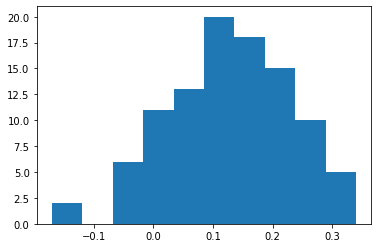

In [52]:
plt.hist(ls) 
plt.show()

In [53]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.129


### Counterfactual fairness

In [54]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in tqdm.tqdm(range(100)):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        s = trace.nodes['sex']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['priors_count']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(0)})
        counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]

100%|██████████| 100/100 [00:02<00:00, 35.00it/s]


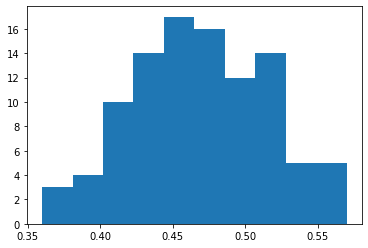

In [55]:
plt.hist(ls)
plt.show()

In [56]:
total = 0
for x in ls:
    total = total + x
print(total / len(ls))

0.4687000000000001


### Average Total Effects

In [101]:
# E(Y|do(X=1))−E(Y|do(X=0)).
e1_samples = [pyro.do(model, data={'race': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(model, data={'race': torch.tensor(0)})() for _ in range(1000)]
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)
e1_avg - e2_avg

-0.14400000000000002

### Natural effects

#### Natural Direct Effects

In [102]:
# When Z = 1 E(Y|(M = 1), do(X = 1)) - E(Y|(M = 1), do(X = 0))
cond_model = pyro.condition(model, data={'priors_count': torch.tensor(0)})
e1_samples = [pyro.do(cond_model, data={'race': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'race': torch.tensor(0)})() for _ in range(1000)]

In [103]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [104]:
e1_avg

0.291

In [105]:
e2_avg

0.375

In [106]:
e1_avg - e2_avg

-0.08400000000000002

#### Natural Indirect Effects

In [107]:
# NIE = E(Y | M=1, do(X=0)) – E(Y | M=0, do(X=0))
cond_model_1 = pyro.condition(model, data={'priors_count': torch.tensor(1)})
cond_model_2 = pyro.condition(model, data={'priors_count': torch.tensor(0)})
e1_samples = [pyro.do(cond_model_1, data={'race': torch.tensor(0)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model_2, data={'race': torch.tensor(0)})() for _ in range(1000)]

In [108]:
e1_avg = sum(e1_samples).item() / len(e1_samples)
e2_avg = sum(e2_samples).item() / len(e2_samples)

In [109]:
e1_avg - e2_avg

0.246

### Necessity and Sufficienty

#### Necessity

$P_{necessity} = P(Y_{X=0} = 0 | X=1, Y=1)$

In [110]:
cond_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(1)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_necessities = []
for _ in range(1000):
    trace = posterior()
    s = trace.nodes['sex']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['priors_count']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(0)})
    counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_necessities.append(float(trace.nodes['two_year_recid']['value']))

In [111]:
p_necessity = 1 - mean(p_necessities)
print("P necessity =", p_necessity)

P necessity = 0.514


#### Sufficiency

In [112]:
cond_model = pyro.condition(model, data = {"race": torch.tensor(0), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(cond_model, num_samples=num_sample).run()
p_sufficiencies = []
for _ in range(1000):
    trace = posterior()
    s = trace.nodes['sex']['value']
    a = trace.nodes['age_cat']['value']
    c = trace.nodes['priors_count']['value']
    do_model = pyro.do(model, data = {"race": torch.tensor(1)})
    counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'priors_count': c })
    trace_counterfactual = pyro.poutine.trace(counterfactual_model)
    trace = trace_counterfactual.get_trace()
    p_sufficiencies.append(float(trace.nodes['two_year_recid']['value']))

In [113]:
p_sufficiency = mean(p_sufficiencies)
print("P necessity =", p_sufficiency)

P necessity = 0.391
